# _Long/Short Strategy Portfolio Analyses_

The following notebook will introduce you a performance analyses of our L/SH strategy for a timeline of 105 months between 2011 and 2019. Our benchmark is the EONIA +4% (per year) and fees are applied annually.

How to spread 4% per year into monthly returns ? We assume that +4% per year = to 0.327% per month ($x^{12}= 1.04 \iff x= 0.00327$). Then, we add this constant float to EONIA monthly rates. We will call this new series EONIA4.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from texttable import Texttable
from scipy.stats import kurtosis, skew
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import scipy
from scipy.stats import skewnorm

import warnings
warnings.filterwarnings("ignore")

In [3]:
data= pd.read_csv("../data/long_short_return_.csv")
data['date'] = pd.to_datetime(data['date'])
data['eonia_4'] = (data['eonia'].str.replace(',','.').astype(float)/100)+ 0.00327
data['eonia'] = (data['eonia'].str.replace(',','.').astype(float)/100)
data['effectif'] = data['effectif']/100
data['pred'] = data['pred']/100
data.head()

,date,effectif,pred,eonia,eonia_4
0,2011-03-01,0.101529,0.091594,0.00659,0.00986
1,2011-04-01,0.051643,0.149672,0.00966,0.01293
2,2011-05-01,0.038508,0.132326,0.01033,0.01360
3,2011-06-01,-0.013343,0.131231,0.01124,0.01451
4,2011-07-01,-0.092120,0.106597,0.01012,0.01339


### A). Quick statistics

In [4]:
t = Texttable()
t.add_rows([['Series', 'Mean Return', 'Std', 'Kurtosis', 'Skewness'], 
            ['EONIA +4%', str(round(data['eonia_4'].mean()*100,2))+'%', str(round(data['eonia_4'].std()*100,2))+'%',
             str(round(kurtosis(data['eonia_4']),2)),  str(round(skew(data['eonia_4']),2))], 
            
            ['Portfolio', str(round(data['effectif'].mean()*100,2))+'%', str(round(data['effectif'].std()*100,2))+'%',
              str(round(kurtosis(data['effectif']),2)),  str(round(skew(data['effectif']),2))
            ]])

print(t.draw())
ex_ret = (round((data['effectif'].mean()*100-data['eonia_4'].mean()*100),3)) 
print('The Excess Return of our Portfolio on average is: '+str(ex_ret)+'% compared to our benchmark (EONIA4)')

+-----------+-------------+-------+----------+----------+
|  Series   | Mean Return |  Std  | Kurtosis | Skewness |
+===========+=============+=======+==========+==========+
| EONIA +4% | 0.29%       | 0.39% | 1.240    | 1.330    |
+-----------+-------------+-------+----------+----------+
| Portfolio | 0.26%       | 4.42% | 1.810    | -0.300   |
+-----------+-------------+-------+----------+----------+
The Excess Return of our Portfolio on average is: -0.034% compared to our benchmark (EONIA4)


### Je propose de supprimer ce graph, il est pas cool


- The chart shows the difference in volatility of our two series, clearly our Portfolio is more volatile. 
- Correlation between our series: -9.4%


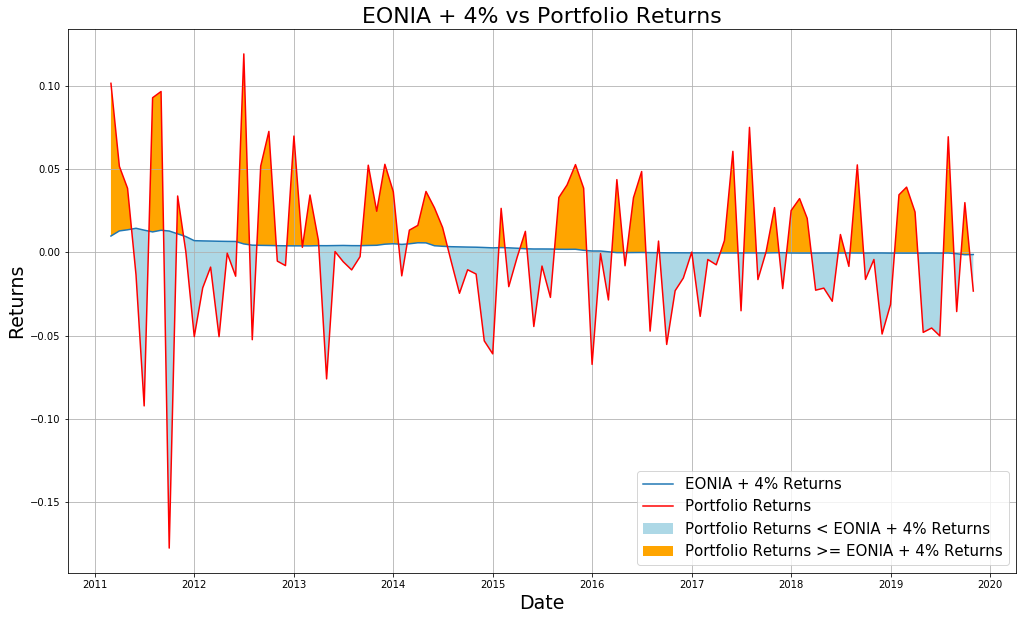

In [5]:
plt.figure(figsize=(17,10))
plt.plot(data.date, data.eonia_4, label='EONIA + 4% Returns')
plt.plot(data.date, data.effectif, c='r', label='Portfolio Returns')

# If our portfolio return is above EONIA + 4%, then color the area between SP and portfolio return in tomato
# else fill with lightblue
plt.fill_between(data["date"], data["eonia_4"], data["effectif"]
                , where= data["eonia_4"] > data["effectif"]
                , facecolor= "lightblue"
                , interpolate= True
                , label= "Portfolio Returns < EONIA + 4% Returns")
plt.fill_between(data["date"], data["eonia_4"], data["effectif"]
                , where= data["eonia_4"] <= data["effectif"]
                , facecolor= "orange"
                , interpolate= True
                , label= "Portfolio Returns >= EONIA + 4% Returns")


plt.title('EONIA + 4% vs Portfolio Returns', size = 22)
plt.xlabel('Date', fontsize=19)
plt.ylabel('Returns', fontsize=19)
plt.legend(prop={'size': 15})
plt.grid()
print('\n- The chart shows the difference in volatility of our two series, clearly our Portfolio is more volatile.',
     '\n- Correlation between our series: '+str(round(data.corr().iloc[0,1],3)*100)+'%')
plt.show()

_Our Portfolio on average under-performs the benchmark with a higher standard deviation (fees not included)._

dvskdmskm






###########################################
_Our Portfolio on average outperforms the benchmark with a lower standard deviation (fees not included)._
    
_By the rule of thumb if the skewness is between -0.5 and 0.5, the data are fairly symmetrical ; if the skewness is between -1 and -0.5(negatively skewed) or between 0.5 and 1(positively skewed), the data are moderately skewed ; if the skewness is less than -1(negatively skewed) or greater than 1(positively skewed), the data are highly skewed. SPX is negatively skewed, and our Portfolio is sim-neg skewed, the reason why we beat our benchmark. This is better shown in the chart above. Indeed, visually we see the difference between the fitted normal distribution and fitted skewed normal distribution for the Portfolio returns which is not observed with the SPX returns distribution. This means that our Portfolio returns distribution are slightly right from the normal one, ergo this explains the good performance of our Portfolio._

_Kurtosis is a statistical measure that defines how heavily the tails of a distribution differ from the tails of a normal distribution. In other words, kurtosis identifies whether the tails of a given distribution contain extreme values. A large kurtosis is associated with a high level of risk of an investment because it indicates that there are high probabilities of extremely large and extremely small returns. On the other hand, a small kurtosis signals a moderate level of risk because the probabilities of extreme returns are relatively low. 
Note: Scipy Kurtosis is calculated using the the Fisher methods which compares our Kurtosis with the normal one. So the result is calculated using Kurt - 3. Our Portfolio has less extreme events compared to the normal one and the SPX has more extreme ones. This was better shown in the charts shown above, the SPX tails go beyond (fat tails) compared to our Portfolio (SPX goes from -0.1 to 0.1 vs Portfolio -0.06 to 0.08). This was expected just by watching the standard deviation of the returns._

_Finally we think that our dataset is not long enough to get a conclusion about the normality of our returns. We only have 10 years of data (aprox ~ 120 points), which is the limit._ 

_Lastly the ACF (Autocorrelation function) and the PACF (Partial Autocorrelation function) shows some signals that we were expecting, for example, we find that the previous month returns are correlated with the current month. In addition we find the lag 4 to also correlated with the current one, since we down-scaled our 10-K results, we expect correlation between 2 quarters, therefore correlation between 1-6 months. However, the correlations are found to be significant right at the edge of the 5% confidence interval. To conclude, we take those lags as significant so we don't think that we are in the presence of a random walk._ 
   
_All the results are shown better shown above._

### B). Notes about normality distribution, random walk and extreme returns

In [6]:
# Normality distribution of our returns

def compare_hist_to_norm(data, bins= 25):
    fig= plt.figure(figsize= (10, 5))
    # mu, std, sk, k= scipy.stats.norm.stats(data, moments='mvsk')
    mu, std= scipy.stats.norm.fit(data)
    # params= scipy.stats.norm.fit(data)
    # sk= scipy.stats.skewnorm(data)
    # Plot l'hist
    plt.hist(data, bins= bins, density=True, alpha=0.6,
    color='purple', label= "Données")
    # Plot le PDF.
    
    xmin, xmax= plt.xlim()
    X= np.linspace(xmin, xmax)
    
    plt.plot(X, scipy.stats.norm.pdf(X, mu, std), label= "Normal Distribution")
    plt.plot(X, skewnorm.pdf(X, *skewnorm.fit(data)), color= 'black', label= "Skewed Normal Distribution")
    
    mu, std= scipy.stats.norm.fit(data)
    sk= scipy.stats.skew(data)
    
    title2= "Moments mu: {}, sig: {}, sk: {}".format(round(mu,4), round(std, 4), round(sk, 4))
    plt.ylabel("Fréquence", rotation= 90)
    plt.title(title2)
    plt.legend()
    
    plt.show()

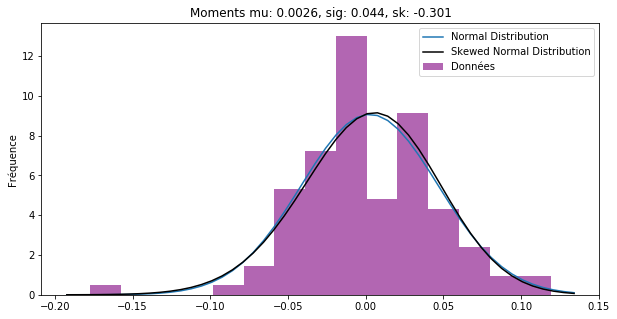

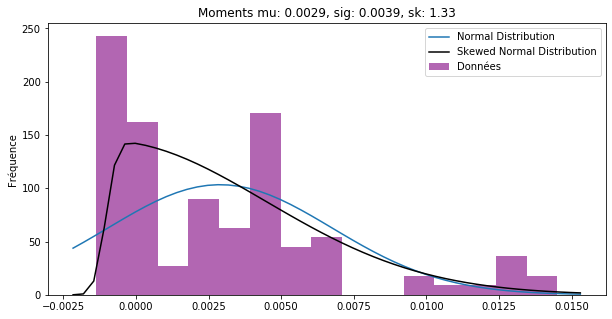

In [7]:
# Our portfolio returns
# warning, we rounded those returns to make the plot more aggragated
compare_hist_to_norm([round(val, 5) for val in data["effectif"].values], bins= 15)

# EONIA distribution
# warning, we rounded those returns to make the plot more aggragated
compare_hist_to_norm([round(val, 5) for val in data["eonia_4"].values], bins= 15)

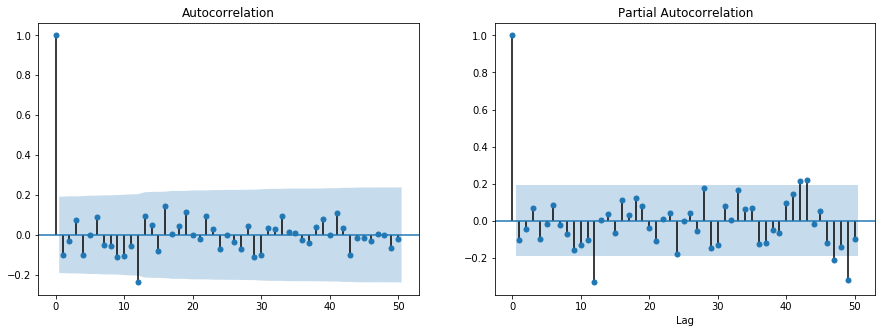

In [8]:
# Autocorrelation for all periods (with confidence intervals)

fig, ax = plt.subplots(1,2,figsize=(15,5))
plot_acf(data["effectif"], lags= 50 , ax=ax[0])
plt.xlabel("Lag")
# partial autocorr
plot_pacf(data["effectif"], lags= 50,ax=ax[1])
plt.xlabel("Lag")
plt.show()

COMMENTAIRES

### C). Rolling metrics

In [9]:
# Rolling metrics
window= 36
lag= 1 # for autocorrelation

effectif_rolling_mean= data["effectif"].rolling(window).mean()
effectif_rolling_mean.index= data["date"]
effectif_rolling_std= data["effectif"].rolling(window).std()
effectif_rolling_std.index= data["date"]
effectif_rolling_autocorr= data["effectif"].rolling(window).apply(
    lambda row: pd.Series(row).autocorr(lag))
effectif_rolling_autocorr.index= data["date"]


sp_rolling_mean= data["eonia_4"].rolling(window).mean()
sp_rolling_mean.index= data["date"]
sp_rolling_std= data["eonia_4"].rolling(window).std()
sp_rolling_std.index= data["date"]
sp_rolling_autocorr= data["eonia_4"].rolling(window).apply(
    lambda row: pd.Series(row).autocorr(lag))
sp_rolling_autocorr.index= data["date"]

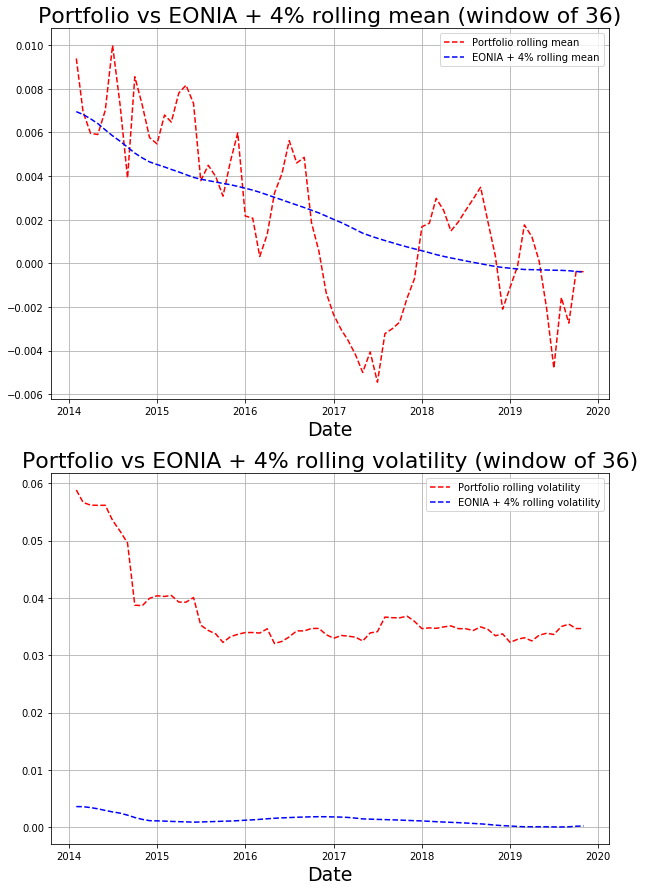

In [10]:
# PLot rolling metrics

# fig= plt.figure(figsize= (20, 30))
ligne= 2
fig, ax= plt.subplots(ligne, 1, figsize= (10, 15))

legend_dico= {0: "mean", 1: "volatility"}
def return_title(i, dic= legend_dico, window= window):
    return "Portfolio vs EONIA + 4% rolling {} (window of {})".format(dic[i], window)

# Rolling mean
mean= return_title(0)
ax[0].plot(effectif_rolling_mean, linestyle= "--", color= "red"
         , label= "Portfolio rolling {}".format(legend_dico[0]))
ax[0].plot(sp_rolling_mean, linestyle= "--", color= "blue"
         , label= "EONIA + 4% rolling {}".format(legend_dico[0]))
ax[0].set_title(mean, size= 22)

# Rolling std
std= return_title(1)
ax[1].plot(effectif_rolling_std, linestyle= "--", color= "red"
         , label= "Portfolio rolling {}".format(legend_dico[1]))
ax[1].plot(sp_rolling_std, linestyle= "--", color= "blue"
         , label= "EONIA + 4% rolling {}".format(legend_dico[1]))
ax[1].set_title(std, size= 22)

for i in range(ligne):
    ax[i].set_xlabel("Date", fontsize= 19)
    ax[i].grid()
    ax[i].legend()

plt.show()

COMMENTAIRES

### D). Portfolio evaluation

#### 1).

In [11]:
#################### FEES #######################################
df = data.copy()

fees = (1.01)**(1/12) - 1

df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['withfees'] = df['effectif'] - fees

# We create a two lists to iterate for creating slices of dataframe 

a = [0] + (list(df[df['month'] == 12].index)) 
b =  (list(df[df['month'] == 12].index)) + [104]

# The length of the two should match

len(a) == len(b)

True

In [12]:
# List that will keep the final values
portfolio_final = []

for l1,l2 in zip(a,b):
    
    # This "if" catches the year that we had only 10 months
    if l2 - l1 < 11:
        
        # It slices the dataframes and it takes the the cumprud of those current slices
        slice_df =  df.iloc[ l1: l2+1]
        spxcpr = (1 + slice_df['eonia_4'].values).cumprod()
        pptcpr = (1 + slice_df['withfees'].values).cumprod()
        
        # Transforming the excess return fee into monthly instalments.
        bonus = (1+(pptcpr[-1]-spxcpr[-1])*(0.2))**(1/(10)) - 1
        
        # If we beat our benchmark, a 20% fee on the excess return is applied monthly.
        if pptcpr[-1] > spxcpr[-1]:

            perfo_fees= slice_df['withfees'].values - bonus
        else:
            perfo_fees= slice_df['withfees'].values
    
        portfolio_final.append(perfo_fees)     
        
    # This "if" catches the years that are full 12 months
    elif l2 - l1 == 12:
        
        slice_df = df.iloc[ l1+1: l2+1] 
        spxcpr = (1 + slice_df['eonia_4'].values).cumprod()
        pptcpr = (1 + slice_df['withfees'].values).cumprod()
        
        bonus = (1+(pptcpr[-1]-spxcpr[-1])*(0.2))**(1/(12)) - 1

        if pptcpr[-1] > spxcpr[-1]:

            perfo_fees= slice_df['withfees'].values - bonus
        else:
            perfo_fees= slice_df['withfees'].values
    
        portfolio_final.append(perfo_fees)
        
    # This "if" catches the years that we had 11 months
    elif l2 - l1 == 11 : 

        slice_df = df.iloc[ l1+1: l2+1] 
        spxcpr = (1 + slice_df['eonia_4'].values).cumprod()
        pptcpr = (1 + slice_df['withfees'].values).cumprod()

        bonus = (1+(pptcpr[-1]-spxcpr[-1])*(0.2))**(1/(11)) - 1
        
        if pptcpr[-1] > spxcpr[-1]:

            perfo_fees= slice_df['withfees'].values - bonus
        else:
            perfo_fees= slice_df['withfees'].values
    
        portfolio_final.append(perfo_fees) 

# Adding the final transformed returns after taking out the management fees and the excess return fee. 
df['final_ppt'] = np.concatenate(portfolio_final, axis=0)
data2= df.copy()

In [13]:
t = Texttable()
t.add_rows([['Series', 'Total Return' ,'Annualized Total Return' ], 
            ['EONIA4', str(round(list((1+data['eonia_4']).cumprod())[-1]-1,3)*100)+'%',
            str(round(((1+round(list((1+data['eonia_4']).cumprod())[-1]-1,2))**(12/len(data)) - 1)*100,2))+'%'] ,
            
            ['Portfolio (without fees)',  str(round(list((1+data['effectif']).cumprod())[-1]-1,3)*100)+'%',
             str(round(((1+round(list((1+data['effectif']).cumprod())[-1]-1,2))**(12/len(data)) - 1)*100,2))+'%'
            ],
            
            ['Portfolio (with fees)',  str(round(list((1+data2['final_ppt']).cumprod())[-1]-1,2)*100)+'%',
             str(round(((1+round(list((1+data2['final_ppt']).cumprod())[-1]-1,2))**(12/len(data)) - 1)*100,2))+'%'
            ]
           ])
print(t.draw())

+--------------------------+--------------+-------------------------+
|          Series          | Total Return | Annualized Total Return |
+==========================+==============+=========================+
| EONIA4                   | 35.4%        | 3.49%                   |
+--------------------------+--------------+-------------------------+
| Portfolio (without fees) | 18.0%        | 1.91%                   |
+--------------------------+--------------+-------------------------+
| Portfolio (with fees)    | 6.0%         | 0.67%                   |
+--------------------------+--------------+-------------------------+


In [14]:
def alpha_beta(x,y,verbose = True):
    
    import statsmodels.api as sm
    from statsmodels import regression
    
#     x = x.values
#     y = y.values
    
    # Adding constant
    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y,x).fit()
    
    alpha, beta = model.params[0], model.params[1]
    if verbose == True:
        t = Texttable()
        t.add_rows([['Benchmark', 'Alpha' , 'Beta'], 
            ['EONIA4', str(round(alpha*100,3))+' %',str(round(beta,2))]])
        print(t.draw())
    else:
        return alpha, beta
    
print('The results are shown for the entire period (wihtout fees)')
alpha_beta(data["eonia_4"].values, data["effectif"].values)

print('\nThe results are shown for the entire period (with fees)')
alpha_beta(data2["eonia_4"].values, data2["final_ppt"].values)

The results are shown for the entire period (wihtout fees)
+-----------+---------+-------+
| Benchmark |  Alpha  | Beta  |
+===========+=========+=======+
| EONIA4    | 0.014 % | 0.830 |
+-----------+---------+-------+

The results are shown for the entire period (with fees)
+-----------+----------+-------+
| Benchmark |  Alpha   | Beta  |
+===========+==========+=======+
| EONIA4    | -0.092 % | 0.830 |
+-----------+----------+-------+


COMMENTAIRES

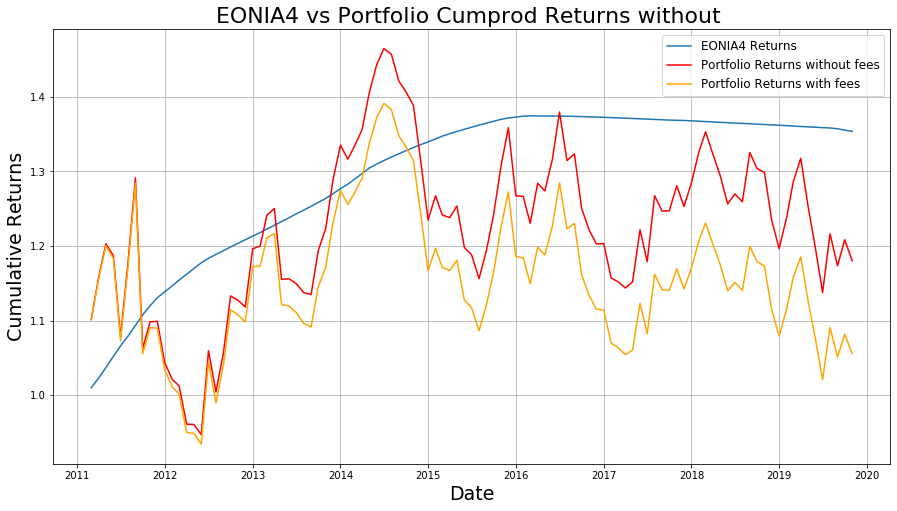

In [15]:
plt.figure(figsize=(15,8))
plt.plot(data.date,(1+data['eonia_4']).cumprod(),label='EONIA4 Returns')
plt.plot(data.date,(1+data['effectif']).cumprod(), c='r', label='Portfolio Returns without fees')
plt.plot(data2.date,(1+data2['final_ppt']).cumprod(), c='orange', label='Portfolio Returns with fees')
plt.title('EONIA4 vs Portfolio Cumprod Returns without ', size = 22)
plt.xlabel('Date', fontsize=19)
plt.ylabel('Cumulative Returns', fontsize=19)
plt.legend(prop={'size': 12})
plt.grid()
plt.show()

#### 2).

In [16]:
# This function will create windows 
def windows(iterable, n, m=1):
    length = len(iterable)
    i = 0

    while i + n < length:
        yield list(iterable[i:i + n+1])
        i += m

In [17]:
roll_alpha = []
roll_beta = []

for be, al in zip((windows(data["eonia_4"], 36, 1)),(windows(data["effectif"], 36, 1))):
    alph,be = alpha_beta(be, al,False)
    roll_alpha.append(alph)
    roll_beta.append(be)

roll_alpha_before= roll_alpha
roll_beta_before= roll_beta

roll_alpha = []
roll_beta = []

for be, al in zip((windows(data2["eonia_4"], 36, 1)),(windows(data2["final_ppt"], 36, 1))):
    alph,be = alpha_beta(be, al,False)
    roll_alpha.append(alph)
    roll_beta.append(be)


- The chart shows the rolling Alpha with a window of 36


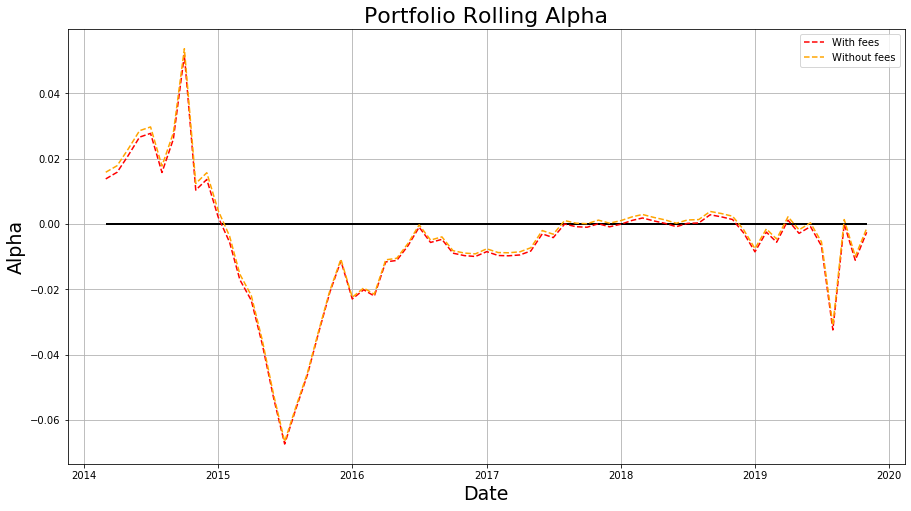

In [18]:
plt.figure(figsize=(15,8))
plt.plot(data2.date.values[-len(roll_alpha):]
         , roll_alpha, label="With fees"
         , color= "red", linestyle= "--")

plt.plot(data2.date.values[-len(roll_alpha_before):]
         , roll_alpha_before, label='Without fees'
         , color= "orange", linestyle= "--")

plt.hlines(np.repeat(0, len(roll_alpha))
           , xmin= data2.date.values[-len(roll_alpha_before):][0]
           , xmax= data2.date.values[-len(roll_alpha_before):][-1]
           , color= "black"
          )

plt.title('Portfolio Rolling Alpha', size = 22)
plt.xlabel('Date', fontsize=19)
plt.ylabel('Alpha', fontsize=19)
plt.grid()
plt.legend()
print('\n- The chart shows the rolling Alpha with a window of 36')
plt.show()


- The chart shows the rolling Beta with a window of 36 points.


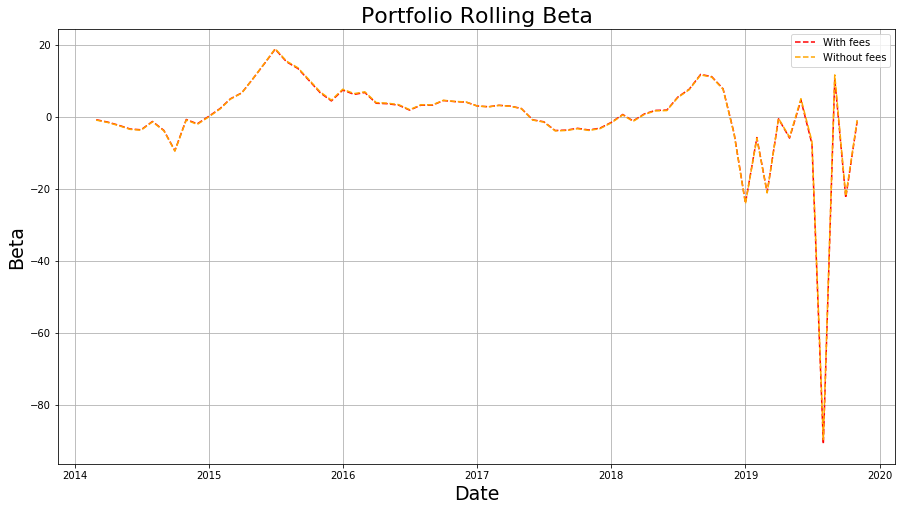

In [19]:
plt.figure(figsize=(15,8))
plt.plot(data2.date.values[-len(roll_beta):]
         , roll_beta, label='With fees', color= "red", linestyle= "--")

plt.plot(data2.date.values[-len(roll_beta_before):]
         , roll_beta_before, label='Without fees', color= "orange", linestyle= "--")

# plt.vlines(ymin= 0.3, ymax= 0.9, x= "2018")

plt.title('Portfolio Rolling Beta', size = 22)
plt.xlabel('Date', fontsize=19)
plt.ylabel('Beta', fontsize=19)
plt.grid()
plt.legend()
print('\n- The chart shows the rolling Beta with a window of 36 points.')
plt.show()

COMMENTAIRES

#### 3).

COMMENTAIRES